使用 TensorFlow 決策森林預測房價

本筆記本將向您介紹如何在本次比賽提供的房價數據集上使用 

TensorFlow 決策森林訓練基線隨機森林模型。

https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf/input

In [ ]:
import tensorflow_decision_forests as tfdf
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision Forests v1.3.0


決策森林是一系列基於樹的模型，包括隨機森林和梯度提升樹。 它們是處理表格數據的最佳起點，並且在您開始試驗神經網絡之前通常會表現出色（或提供強大的基線）。

# Load the dataset

In [ ]:
train_file_path = "/content/input/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [ ]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


有 79 個特徵列。 使用這些功能，您的模型必須預測名為 SalePrice 的標籤列指示的房屋銷售價格。
我們將刪除 Id 列，因為模型訓練不需要它。

In [ ]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


我們可以使用以下代碼檢查特徵列的類型：

In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

房價分佈

現在讓我們來看看房價是如何分佈的

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<ipython-input-12-dc911a47893e>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


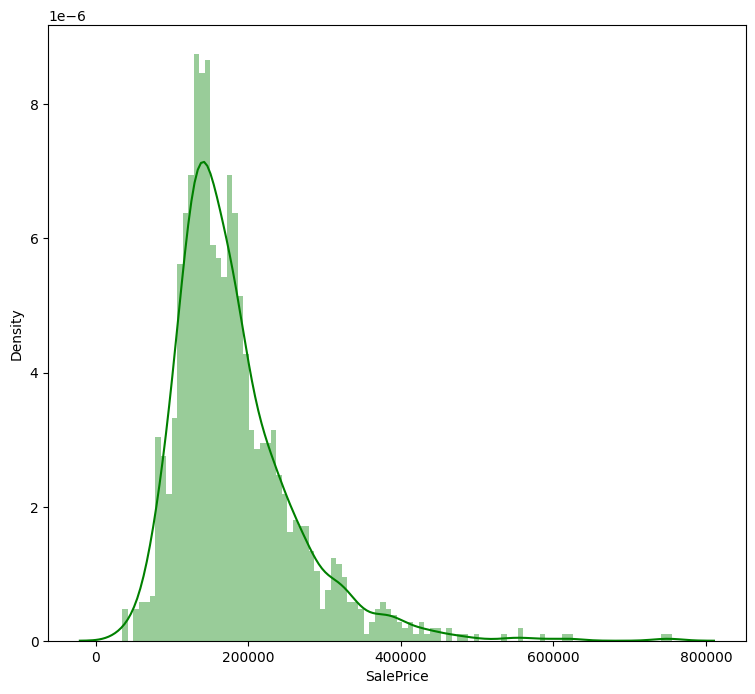

In [ ]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

數值數據分佈

我們現在來看看數值特徵是如何分佈的。 為此，讓我們首先列出數據

集中的所有數據類型，並僅選擇數字數據。

In [ ]:
list(set(dataset_df.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [ ]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


現在讓我們繪製所有數值特徵的分佈。

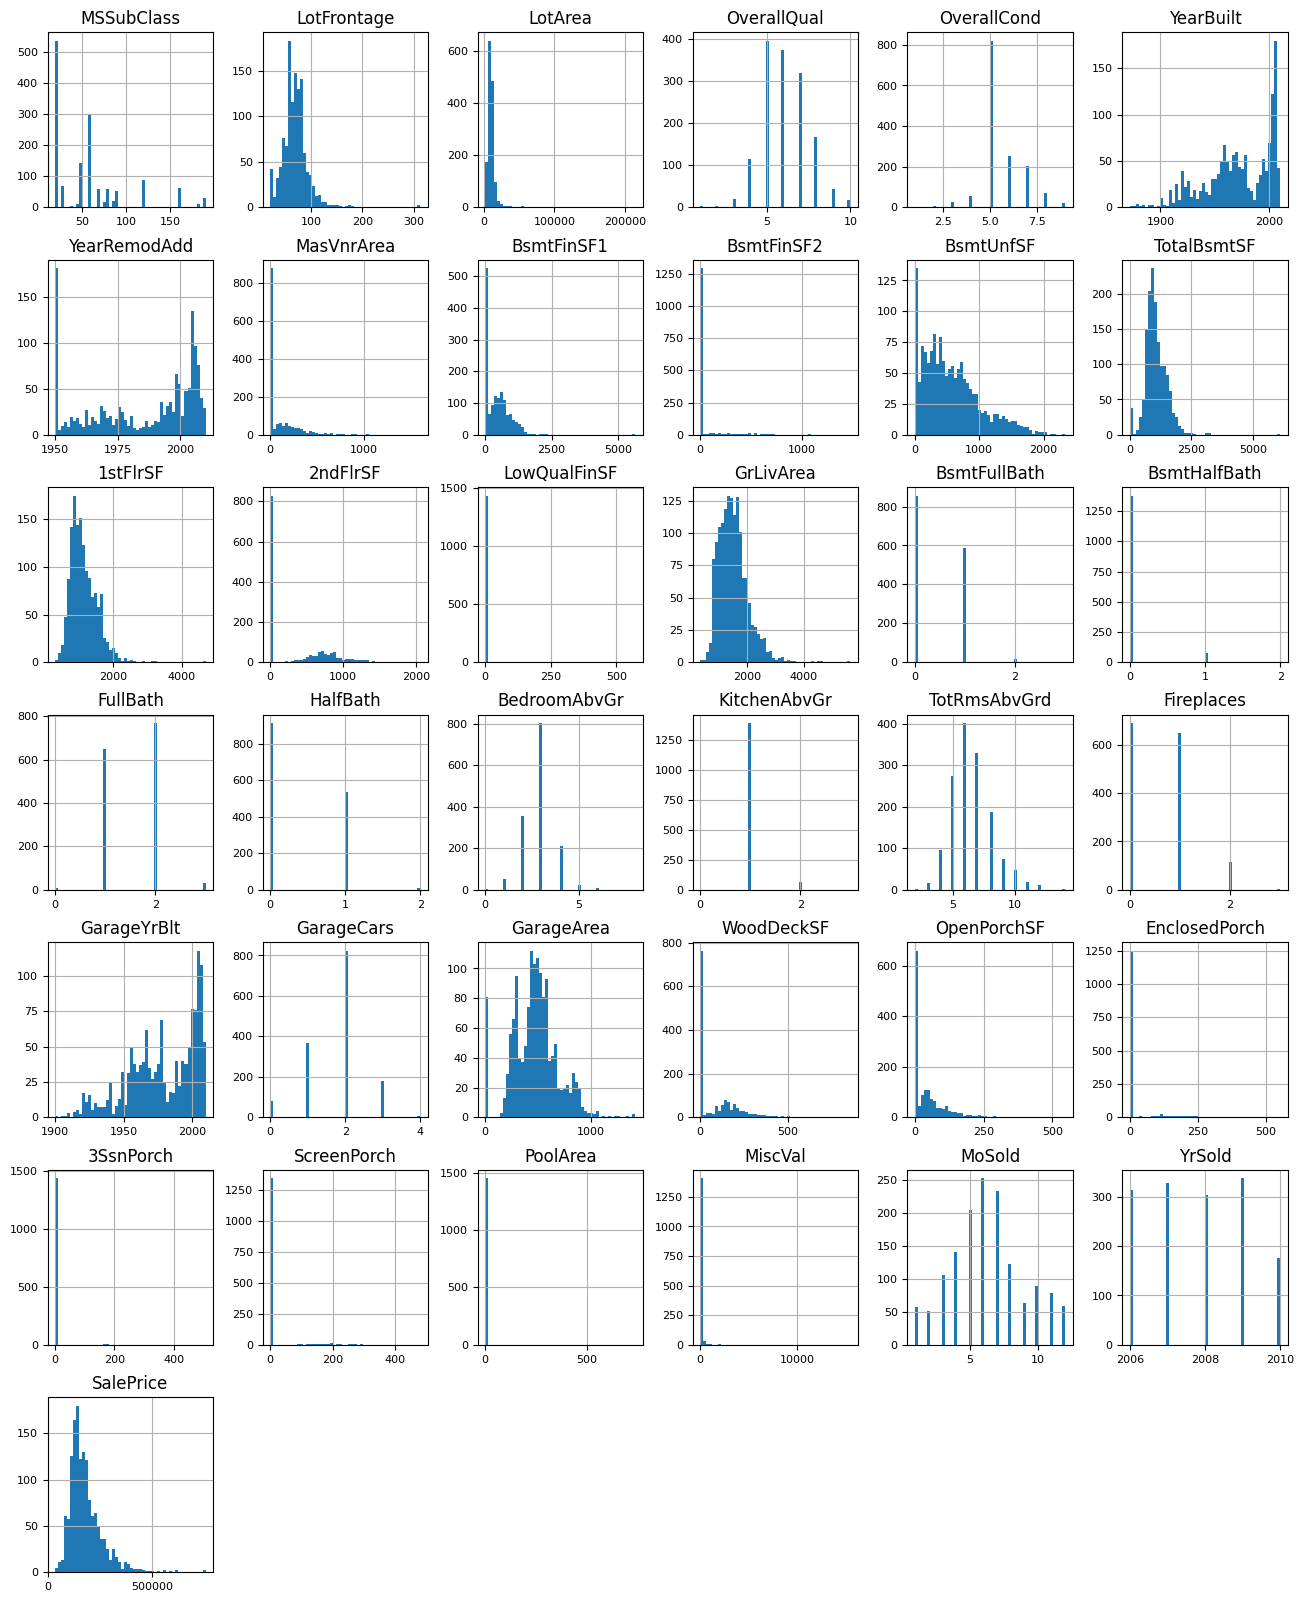

In [ ]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

準備數據集

該數據集包含數字、分類和缺失特徵的混合。 TF-DF 原生支持所有這

些特徵類型，無需預處理。 這是基於樹的模型的一個優勢，使它們成

為 Tensorflow 和 ML 的一個很好的切入點。

現在讓我們將數據集拆分為訓練和測試數據集：

In [ ]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1004 examples in training, 456 examples in testing.


在我們訓練模型之前還需要一個步驟。 我們需要將數據集從 Pandas 格式 (pd.DataFrame) 轉換為 TensorFlow 數據集格式 (tf.data.Dataset)。

TensorFlow Datasets 是一個高性能數據加載庫，在使用 GPU 和 TPU 等加速器訓練神經網絡時非常有用。

默認情況下，隨機森林模型配置為訓練分類任務。 由於這是一個回歸問題，我們將在此處指定任務類型 (tfdf.keras.Task.REGRESSION) 作為參數。

In [ ]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

選擇型號
有幾種基於樹的模型供您選擇。

隨機森林模型
梯度提升樹模型
CART模型
分佈式梯度提升樹模型
首先，我們將使用隨機森林。 這是最著名的決策森林訓練算法。

隨機森林是決策樹的集合，每個決策樹都在訓練數據集的隨機子集上獨立訓練（通過替換採樣）。 該算法的獨特之處在於它對過度擬合具有魯棒性並且易於使用。

我們可以使用以下代碼列出 TensorFlow Decision Forests 中的所有可用模型：

In [ ]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

我該如何配置它們？
TensorFlow Decision Forests 為您提供了良好的默認值（例如，我們的基準測試中排名最高的超參數，稍作修改以在合理的時間內運行）。 如果您想配置學習算法，您會發現許多選項，您可以探索這些選項以獲得盡可能高的準確度。

您可以選擇模板和/或設置參數，如下所示：

rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)

更多配置可以參考
https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel

創建隨機森林

今天，我們將使用默認值創建隨機森林模型，同時將任務類型指定為 

tfdf.keras.Task.REGRESSION。

In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmprk7dinsq as temporary training directory


訓練模型

In [ ]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:05.960929. Found 1004 examples.
Training model...
Model trained in 0:00:03.036506
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


可視化模型

基於樹的模型的一個好處是您可以輕鬆地將它們可視化。 隨機森林中

使用的樹的默認數量是 300。我們可以選擇一棵樹來顯示在下面。

In [ ]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

在袋外 (OOB) 數據和驗證數據集上評估模型

在訓練數據集之前，我們手動分離了 20% 的數據集用於驗證，命名為 valid_ds。

我們還可以使用袋外 (OOB) 分數來驗證我們的 

RandomForestModel。 為了訓練隨機森林模型，算法從訓練集中選擇

一組隨機樣本，其餘樣本用於微調模型。未選擇的數據子集稱為袋外

數據（OOB ). OOB 分數是根據 OOB 數據計算的。

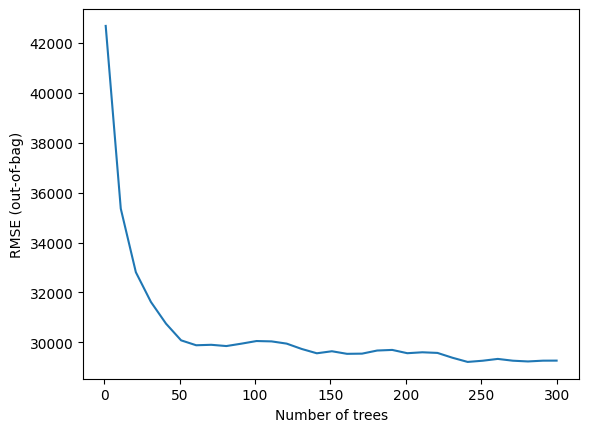

In [ ]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1004, accuracy=None, loss=None, rmse=29272.12860159986, ndcg=None, aucs=None, auuc=None, qini=None)

In [ ]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 737ms/step - loss: 0.0000e+00 - mse: 896747456.0000
loss: 0.0000
mse: 896747456.0000


變量重要性

變量重要性通常表示特徵對模型預測或質量的貢獻程度。 有多種方法

可以使用 TensorFlow 決策森林識別重要特徵。 讓我們列出決策樹的

可用變量重要性：

In [ ]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH


例如，讓我們顯示變量重要性 NUM_AS_ROOT 的重要特徵。

NUM_AS_ROOT 的重要性得分越大，它對模型結果的影響就越大。

默認情況下，列表按從最重要到最不重要的順序排序。 從輸出中，您可以推斷出列表頂部的特徵比任何其他特徵都用作隨機森林中大多數樹的根節點

In [ ]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 134.0),
 ("ExterQual" (4; #22), 43.0),
 ("Neighborhood" (4; #59), 34.0),
 ("GarageCars" (1; #32), 30.0),
 ("GrLivArea" (1; #38), 15.0),
 ("KitchenQual" (4; #44), 12.0),
 ("TotalBsmtSF" (1; #73), 12.0),
 ("GarageArea" (1; #31), 11.0),
 ("BsmtQual" (4; #14), 4.0),
 ("YearBuilt" (1; #76), 3.0),
 ("1stFlrSF" (1; #0), 1.0),
 ("FullBath" (1; #29), 1.0)]

使用 Matplotlib 繪製檢查員的變量重要性

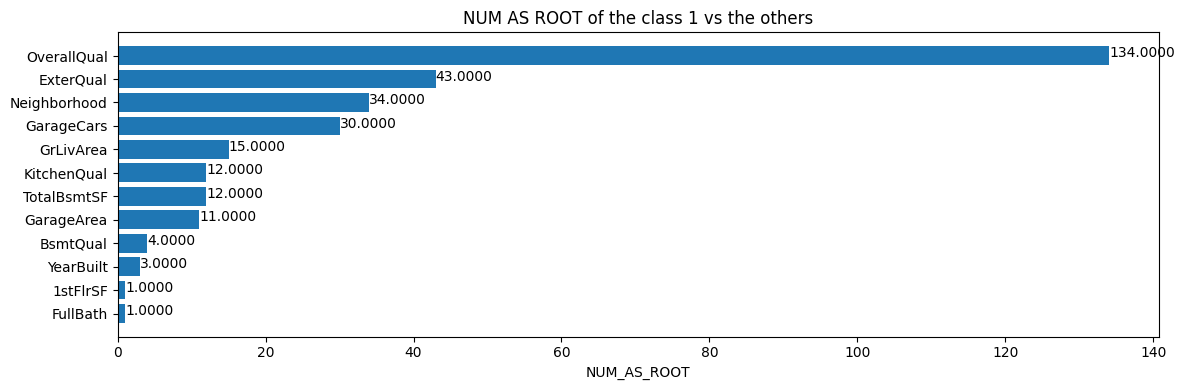

In [ ]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

提交

最後使用模型對競賽測試數據進行預測。

In [ ]:
test_file_path = "/content/input/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 2s 97ms/step


,Id,SalePrice
0,1461,124956.453125
1,1462,154124.718750
2,1463,181046.406250
3,1464,181055.515625
4,1465,198237.484375


In [ ]:
sample_submission_df = pd.read_csv('/content/input/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 35ms/step


,Id,SalePrice
0,1461,124956.453125
1,1462,154124.718750
2,1463,181046.406250
3,1464,181055.515625
4,1465,198237.484375
